## <font color='Blue'>Introduction</font>
###  In this exercise, we run simulation in a 2D single layer two-phase model.
* The realistic formation heterogeneity is used for permeability map. 
* Details of runtime parameters can be found by [DARTS-engine](./darts/html/index.html)

## <font color='blue'>The objectives:</font>
1. Introduce custom <font color='red'>'Model'</font> class based on 
 * Class [DartsModel](http://localhost:8888/edit/darts-workshop/darts/models/darts_model.py) with base model capabilities
 * Class [StructReservoir](http://localhost:8888/edit/darts-workshop/darts/models/reservoirs/struct_reservoir.py) with structured reservoir
 * Class [Deadoil](http://localhost:8888/edit/darts-workshop/darts/models/physics/dead_oil_python.py) for basic dead oil physics
 * Class [Deadoil-properties](http://localhost:8888/edit/darts-workshop/darts/models/physics/do_properties_python.py) for dead oil properties, such as density, viscosity and relative permeability
2. Use run_python procedure to control run from the python script
3. Introduce wells and time-dependent well controls
4. Redefine physical properties and run simulation with custom-defined property.

## <font color='Blue'>Let's start!</font>


<img style="float: left;" src="slides/Slide33.JPG" width="60%">

In [1]:
from darts.models.reservoirs.struct_reservoir import StructReservoir
from darts.models.physics.dead_oil_python import DeadOil
from darts.models.darts_model import DartsModel
from darts.engines import value_vector
from darts.tools.keyword_file_tools import load_single_keyword
import numpy as np

<img style="float: left;" src="slides/Slide34.JPG" width="60%">

#### Brief Introduction of model inheritance
* Here create the <font color='red'>'Model' </font>  class, which inherits from <font color='red'>DartsModel</font> (the base class).
* It keeps all the functionalities of <font color='red'>DartsModel</font> and can also be extended to add more functionalities.
* If a function is redefined in subclass, the function in base class with identical name will be overridden.

In [2]:
class Model(DartsModel):
    def __init__(self):
        # call base class constructor
        super().__init__()

        # measure time spend on reading/initialization
        self.timer.node["initialization"].start()

        # create reservoir
        self.nx = 60
        self.ny = 60
        self.nz = 1
        
        self.dx = 8
        self.dy = 8
        self.dz = 4

#         self.permx = np.ones(self.nx*self.ny)*1000
#         self.actnum = np.ones(self.nx*self.ny)
        
        self.permx = load_single_keyword('Egg/data.in','PERMX')
        self.actnum = load_single_keyword('Egg/data.in','ACTNUM')       

        self.permy = self.permx
        self.permz = 0.1 * self.permx
        self.poro = 0.2
        self.depth = 4000

        # run discretization
        self.reservoir = StructReservoir(self.timer, nx=self.nx, ny=self.ny, nz=self.nz, dx=self.dx, dy=self.dy,
                                         dz=self.dz, permx=self.permx, permy=self.permy, permz=self.permz,
                                         poro=self.poro, depth=self.depth,actnum=self.actnum)

        # add two wells
        well_diam = 0.2
        well_rad = well_diam/2


            
#         self.reservoir.add_well("INJ1")
#         self.reservoir.add_perforation(self.reservoir.wells[-1], 5, 57, 1, well_radius=well_rad, multi_segment=False)
#         self.reservoir.inj_wells = [self.reservoir.wells[-1]]        

#         self.reservoir.add_well("PRD1")
#         self.reservoir.add_perforation(self.reservoir.wells[-1], 43, 18, 1, well_radius=well_rad, multi_segment=False)
#         self.reservoir.prod_wells = [self.reservoir.wells[-1]]

        inj_loc = [(5, 57), (29, 53), (4, 35), (27, 29), (49, 35), (10, 9), (32, 3), (57, 7)]
        prod_loc = [(16, 43), (35, 40), (23, 16), (43, 18)]
        for i in range(len(inj_loc)):
            self.reservoir.add_well("INJ"+str(i+1))
            self.reservoir.add_perforation(self.reservoir.wells[-1], int(inj_loc[i][0]), int(inj_loc[i][1]), 1, well_radius=well_rad, multi_segment=False)
            self.reservoir.inj_wells = [self.reservoir.wells[-1]]
        for i in range(len(prod_loc)):
            self.reservoir.add_well("PRD"+str(i+1))
            self.reservoir.add_perforation(self.reservoir.wells[-1], int(prod_loc[i][0]), int(prod_loc[i][1]), 1, well_radius=well_rad, multi_segment=False)
            self.reservoir.prod_wells = [self.reservoir.wells[-1]]

        # create physics
        self.physics = DeadOil(timer=self.timer, physics_filename='Egg/physics.in',
                               n_points=201, min_p=300, max_p=500, min_z=1e-8)

        self.params.first_ts = 1
        self.params.mult_ts = 2
        self.params.max_ts = 50
        self.params.tolerance_newton = 1e-2
        self.params.tolerance_linear = 1e-3

        self.inj = [1]

        self.runtime = 500

        self.timer.node["initialization"].stop()

    def set_initial_conditions(self):
        self.physics.set_uniform_initial_conditions(self.reservoir.mesh, uniform_pressure=400,
                                                    uniform_composition=[2e-2])

    def set_boundary_conditions(self):
        for i, w in enumerate(self.reservoir.wells):
            if w.name[:3] == "INJ":
                w.control = self.physics.new_bhp_water_inj(410, self.inj)
                # w.constraint = self.physics.new_rate_water_prod(210)
            else:
                w.control = self.physics.new_bhp_prod(390)

<img style="float: left;" src="slides/Slide35.JPG" width="60%">

In [3]:
m = Model()
m.init()
m.run_python()
m.print_timers()

Reading PERMX from C:\Users\dvosk\darts-workshop\Filled_notebook\Egg\data.in... 3600 values have been read.
Reading ACTNUM from C:\Users\dvosk\darts-workshop\Filled_notebook\Egg\data.in... 3600 values have been read.
Building connection list...
Applying ACTNUM...
Inactive blocks due to ACTNUM:  1109
Inactive connections due to transmissibility:  0
Inactive connections total:  2213
Inactive blocks due to inactive connections:  0
# 1 	T =   1	DT =  1	NI = 4	LI=21
# 2 	T =   3	DT =  2	NI = 4	LI=23
# 3 	T =   7	DT =  4	NI = 4	LI=29
# 4 	T =  15	DT =  8	NI = 6	LI=46
# 5 	T =  31	DT = 16	NI = 9	LI=69
# 6 	T =  63	DT = 32	NI = 13	LI=98
# 7 	T = 113	DT = 50	NI = 15	LI=120
# 8 	T = 163	DT = 50	NI = 9	LI=67
# 9 	T = 213	DT = 50	NI = 8	LI=62
# 10 	T = 263	DT = 50	NI = 11	LI=93
# 11 	T = 313	DT = 50	NI = 7	LI=54
# 12 	T = 363	DT = 50	NI = 7	LI=55
# 13 	T = 413	DT = 50	NI = 5	LI=44
# 14 	T = 463	DT = 50	NI = 4	LI=24
# 15 	T = 500	DT = 37	NI = 1	LI=9
TS = 15(0), NI = 107(0), LI = 814(0)
Total elapse

<img style="float: left;" src="slides/Slide36.JPG" width="60%">

In [4]:
%matplotlib inline
import pandas as pd
time_data = pd.DataFrame.from_dict(m.physics.engine.time_data)
# wirte timedata to output file
time_data.to_pickle("darts_time_data.pkl")
# write timedata to excel file
writer = pd.ExcelWriter('time_data.xlsx')
time_data.to_excel(writer, 'Sheet1')
writer.save()

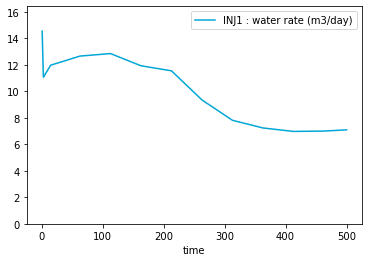

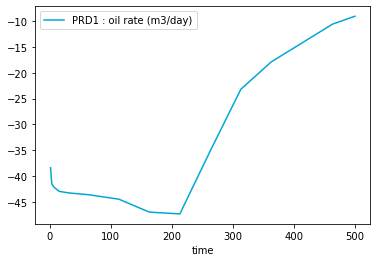

In [5]:
# read data from output file
td = pd.read_pickle("darts_time_data.pkl")
# plot production rates
from darts.tools.plot_darts import *
plot_water_rate_darts('INJ1', time_data)
plot_oil_rate_darts('PRD1', time_data)
plt.show()

<img style="float: left;" src="slides/Slide37.JPG" width="60%">

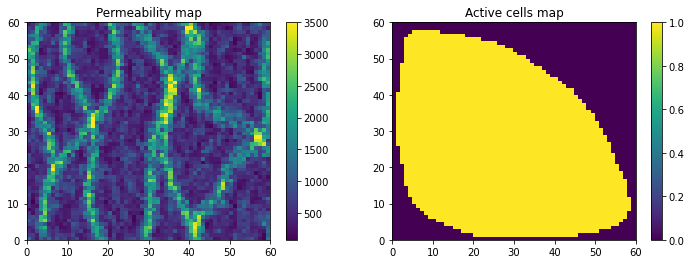

In [6]:
import matplotlib.pyplot as plt
plt.figure(num=1, figsize=(12,4))
plt.subplot(121)
perm = np.array(m.permx)
plt.pcolor(perm.reshape(m.ny, m.nx))
plt.title("Permeability map")
plt.colorbar()

plt.subplot(122)
act = np.array(m.actnum)
plt.pcolor(act.reshape(m.ny, m.nx))
plt.title("Active cells map")
plt.colorbar()

<img style="float: left;" src="slides/Slide38.JPG" width="60%">

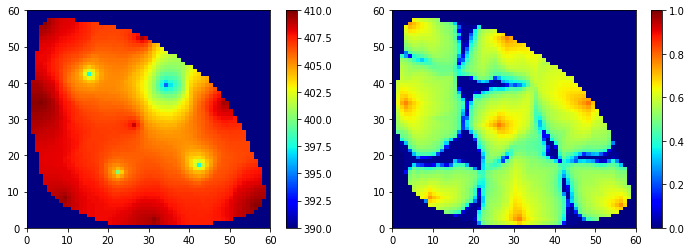

In [7]:
import matplotlib.pyplot as plt
from darts.models.physics.do_operator_python import *

# process active grid
X = np.array(m.physics.engine.X, copy=False)
nb = m.nx * m.ny
nb = np.count_nonzero(m.actnum)

p = -np.ones(m.nx*m.ny)
z = -np.ones(m.nx*m.ny)
s = -np.ones(m.nx*m.ny)

p[act>0] = X[0:2*nb:2]
z[act>0] = X[1:2*nb:2]

plt.figure(num=2, figsize=(12,4))
plt.subplot(121)
plt.pcolor(p.reshape(m.ny, m.nx),cmap='jet')
plt.clim([390,410])
plt.colorbar()

plt.subplot(122)
property_data = property_deadoil_data("Egg/physics.in")
sw_ev = Saturation(property_data)

for i in range(m.nx*m.ny):
    state = value_vector([p[i],z[i]])
    s[i] = sw_ev.evaluate(state)
plt.pcolor(s.reshape(m.ny, m.nx),cmap='jet')
plt.clim([0,1])
plt.colorbar()


<img style="float: left;" src="slides/Slide40.JPG" width="60%">

<img style="float: left;" src="slides/Slide41.JPG" width="60%">

<img style="float: left;" src="slides/Slide42.JPG" width="60%">

<img style="float: left;" src="slides/Slide43.JPG" width="60%">